In [1]:
import tifffile
import numpy as np
from numba import njit, prange
import torch 
import torch.nn as nn 
import torch.optim as optim 
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage.transform import resize
import scipy.ndimage as ndimage
import cv2
import imageio
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.isotonic import IsotonicRegression

# from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve as filter2
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

## 1. Load data

Here read the raw data, which has 4600 frames each.

In [2]:
# dir_data = os.path.join(os.path.pardir, 'data', 'demo')
dir_data = '../iAdo2m_jRGECO1a_raw_data/'
file_iAdo2m = os.path.join(dir_data, 'iAdo2m_27202-31801.tif')
file_jRGECO1a = os.path.join(dir_data, 'jRGECO1a_27202-31801.tif')

if os.path.exists(file_iAdo2m) and os.path.exists(file_jRGECO1a):
    iAdo2m = tifffile.imread(file_iAdo2m)
    jRGEC01a = tifffile.imread(file_jRGECO1a)
    print('Files loaded successfully')
else: 
    print('File loading failed')

print(f'Dimension of iAdo2m: {iAdo2m.shape}')
print(f'Dimension of jRGEC01: {jRGEC01a.shape}')


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Files loaded successfully
Dimension of iAdo2m: (4600, 359, 359)
Dimension of jRGEC01: (4600, 359, 359)


## 2. Exploration and Visualization

### 2-1 inpainting the blood vessel areas 
The blood vessels is annoying for the following analysis. So, it's a good practice to inpaint these  areas using its nearby signals. This peration can be done with the `inpaint` function in openCV. 

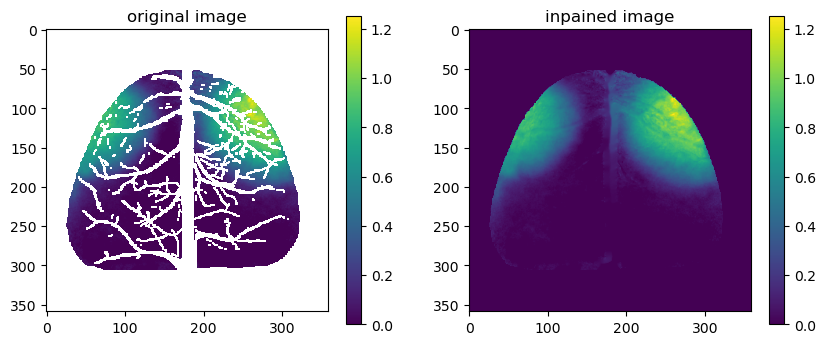

In [3]:
# read a mask for inpaint
file_brain_mask = os.path.join('../Mask.tif')
brain_mask = tifffile.imread(file_brain_mask)
nan_mask = np.isnan(iAdo2m[0])

inpaint_mask = np.logical_and(brain_mask, nan_mask).astype('uint8')

# print(mask)
vmin, vmax = iAdo2m[:, ~nan_mask].min(), iAdo2m[:, ~nan_mask].max()
image = ((iAdo2m[1150]-vmin)/(vmax-vmin)*65536).astype(np.uint16)
img_paint = cv2.inpaint(image, 
            inpaint_mask, 
            10, 
            cv2.INPAINT_NS)/65536.0*(vmax-vmin)+vmin 

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(iAdo2m[1150], vmin=0, vmax=1.25)
plt.colorbar()
plt.title('original image')
plt.subplot(122)
plt.imshow(img_paint, vmin=0, vmax=1.25)
plt.colorbar()
plt.title('inpained image')
plt.show()

We can see that the inpainted images preserves the original signal, while  filling the blood vessel areas with visually appealing values. Thus in the following analysis, we decide to inpaint all frames. 

However, the default inpaint algorithm is slow. Here, we customized a faster inpainting trick, which decompose images with a truncated SVD, and then only inpaint the SVD components. 

In [4]:
def inpaint_video(video, inpaint_mask, n_components=20, inpaint_radius=10): 
    T, w, h = video.shape
    mask = np.logical_or(np.isnan(video[0]), inpaint_mask)
    Y = video[:, ~mask]

    svd = TruncatedSVD(n_components)
    svd.fit(Y[::20])
    V = svd.components_
    coefs = np.dot(Y, V.transpose())

    # inpaint spatial components 
    V_full = np.zeros((V.shape[0], w,h))
    V_full[:, ~mask] = V  

    for i in range(V_full.shape[0]):
        vmin, vmax = V[i].min(), V[i].max()
        image = ((V_full[i]-vmin)/(vmax-vmin)*65536).astype(np.uint16)
        image[mask]  = 0 
        V_full[i] = cv2.inpaint(image, 
                    inpaint_mask.astype(np.uint8), 
                    inpaint_radius, 
                    cv2.INPAINT_NS)/65536.0*(vmax-vmin)+vmin 
    
    video_inpainted =  video.copy()
    video_inpainted[:, inpaint_mask>0] = (coefs @ V_full[:, inpaint_mask>0])
    return video_inpainted

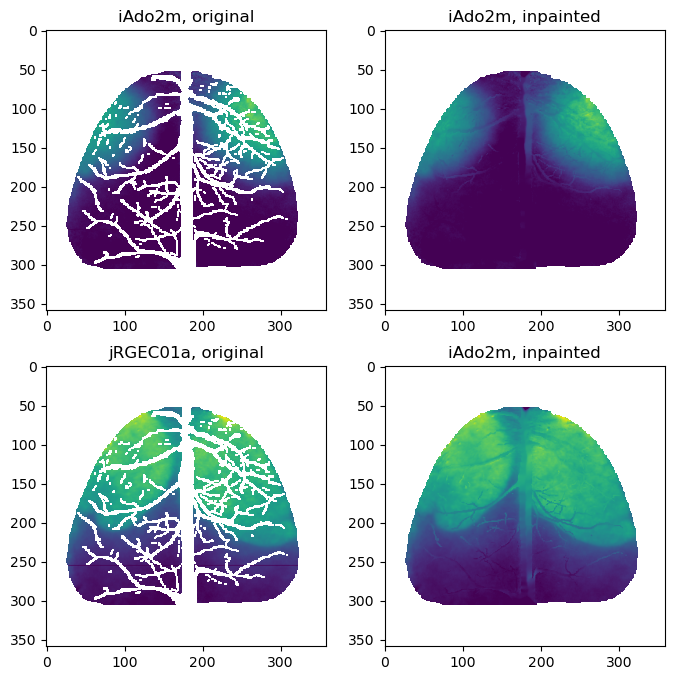

In [5]:
iAdo2m_inpaint = inpaint_video(iAdo2m, inpaint_mask, 20, 10)
jRGEC01a_inpaint = inpaint_video(jRGEC01a, inpaint_mask, 20, 10)

plt.figure(figsize=(8, 8))
t = 1150 # randomly pick one
plt.subplot(221)
image = iAdo2m[t]
image[~brain_mask] = 0 
plt.imshow(image, vmin=0, vmax=1.5)
plt.title('iAdo2m, original')

plt.subplot(222)
plt.imshow(iAdo2m_inpaint[t], vmin=0, vmax=1.5)
plt.title('iAdo2m, inpainted')

plt.subplot(223)
image = jRGEC01a[t]
image[~brain_mask] = 0 
plt.imshow(image, vmin=0, vmax=3)
plt.title('jRGEC01a, original')

plt.subplot(224)
plt.imshow(jRGEC01a_inpaint[t], vmin=0, vmax=3)
plt.title('iAdo2m, inpainted')
plt.show()

Above all, we grasped the whole frames of inpainted images. Later we'll analyse the velocity based on the inpainted data.

### 2-2 Exploratory analysis on the temporal trace of a single pixel 

Here we focus on the circumstance on one pixel, trying to figure out some patterns and then to apply on other pixels. If you want to explore the algorithms of whole pixels, you could jump to 'Chapter 3' to check. 

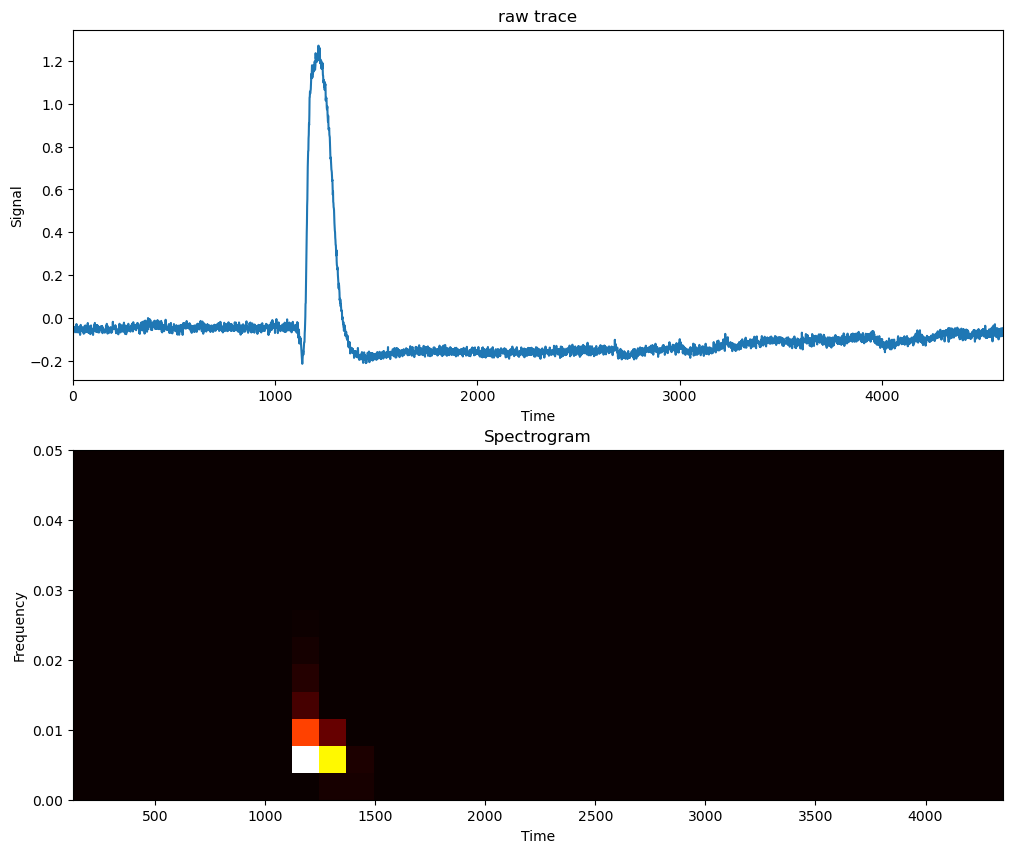

In [6]:
# example trace 
Fs = 1
y = iAdo2m_inpaint[:, 128, 144]

# compute spectrogram 
window = 'hann'  # Window function for the Fourier transform
nperseg = 256    # Length of each segment
noverlap = 128   # Number of samples to overlap between segments

freq, time, spectrogram = signal.spectrogram(y, fs=Fs, window=window, nperseg=nperseg, noverlap=noverlap)

# show results 
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(np.arange(len(y))/Fs, y)
plt.xlim([0, len(y)/Fs])
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('raw trace')

# Plot the spectrogram
plt.subplot(212)
plt.imshow(spectrogram, aspect='auto', cmap='hot', origin='lower', extent=[time.min(), time.max(), freq.min(), freq.max()])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.ylim([0, Fs/20])
plt.title('Spectrogram')
plt.show()

Spectrogram appears in [1000, 1500].

From the results above, we can see that the spectrogram shows an increase in the frequency band below 0.02Hz, corresponding to the large brain activity shown in the raw trace. Next, we will apply a low pass filtering to focus on the activity in this frequency range.  

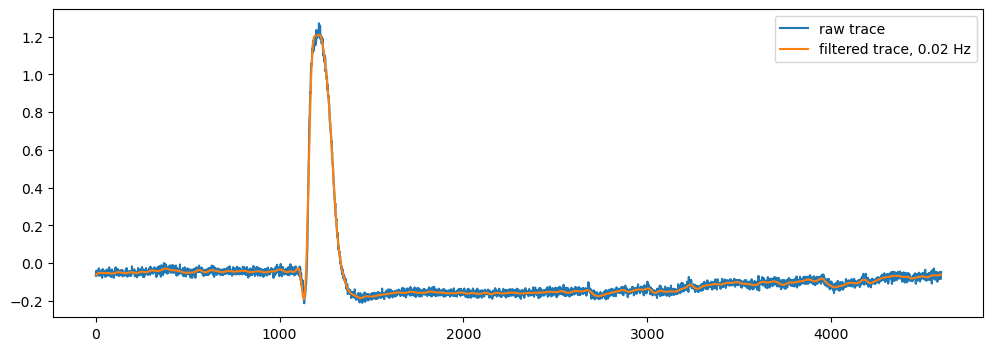

In [7]:
# Normalize the cutoff frequency

normalized_cutoff_1 = 0.02 / (0.5 * Fs)
# normalized_cutoff_2 = 0.3 / (0.5 * Fs)

# Design the low-pass filter
b, a = signal.butter(4, normalized_cutoff_1, btype='low', analog=False)
filtered_y_1 = signal.filtfilt(b, a, y)
# b, a = signal.butter(4, normalized_cutoff_2, btype='low', analog=False)
# filtered_y_2 = signal.filtfilt(b, a, y)

# Apply the filter to the time series

plt.figure(figsize=(12,4))
plt.plot(y, label='raw trace')
plt.plot(filtered_y_1, label='filtered trace, 0.02 Hz')
# plt.plot(filtered_y_2, '-.', label='filtered trace, 0.3 Hz')
plt.legend()
plt.show()

It seems that apply a low-pass filtering of 0.2 Hz yields a smoother trace while capturing all main brain activity. In the following, we will apply this low-pass filtering to all traces of iAdo data.  

### 2-3 Hilbert transform 
Hilbert transform can be used to  extract the instantaneous phase of a signal. Based on Chapter 3, here we continue analysing the single pixel. 

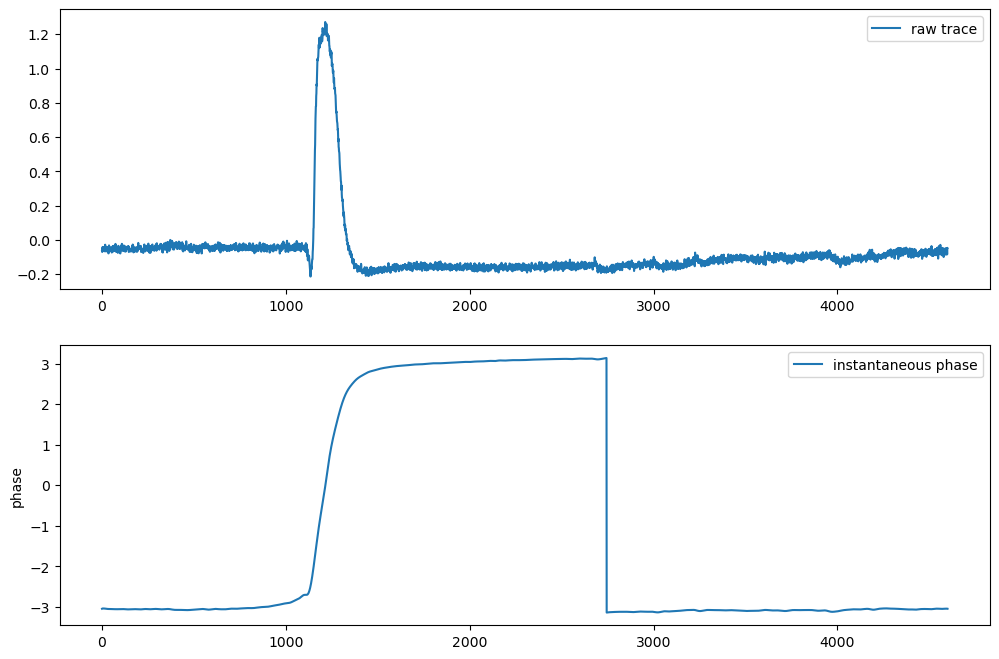

In [8]:
normalized_cutoff = 0.02 / (0.5 * Fs)

# Design the low-pass filter
b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
y_filtered = signal.filtfilt(b, a, y)
y_filtered -= np.ptp(y_filtered)/2.0 
y_hilbert = signal.hilbert(y_filtered)  

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(y, label='raw trace')
# plt.plot(np.abs(y_hilbert), label='amplitude')
plt.legend()

ax_phase = plt.subplot(212)
ax_phase.plot(np.angle(y_hilbert), label='instantaneous phase')
ax_phase.legend()
plt.ylabel('phase')
plt.show()

### 2-4 Instantaneous angular velocity 

Given the instantaneous phase, we  can also compute the instantaneous angular velocity $w=\phi'(t)$. Naively differentiating the phase may yield negative velocity. Thus we customize this calculation by constraining nonnegative $w$. This corresponds to isotonic regression. 

In [9]:
def isotonic_phase(phase): 
    iso_reg = IsotonicRegression().fit(np.arange(len(phase)), phase)
    phase_pred = iso_reg.predict((np.arange(len(phase))))
    return phase_pred

def preprocess(traces, normalized_cutoff):
    b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
    if len(traces.shape)==1:
        traces = traces[:, np.newaxis]
    y_filtered = signal.filtfilt(b, a, traces, axis=0)
    y_filtered -= np.ptp(y_filtered,  axis=0)/2.0 
    y_hilbert = signal.hilbert(y_filtered, axis=0)  
    phase = np.unwrap(np.angle(y_hilbert), axis=0)
    if len(phase.shape)==2: 
        for i in range(phase.shape[1]): 
            phase[:, i] = isotonic_phase(phase[:, i])   
    else: 
        for i in range(phase.shape[1]):
            for j in range(phase.shape[2]):
                phase[:, i, j] = isotonic_phase(phase[:, i, j])
        
    return y_hilbert.squeeze(), phase.squeeze() 

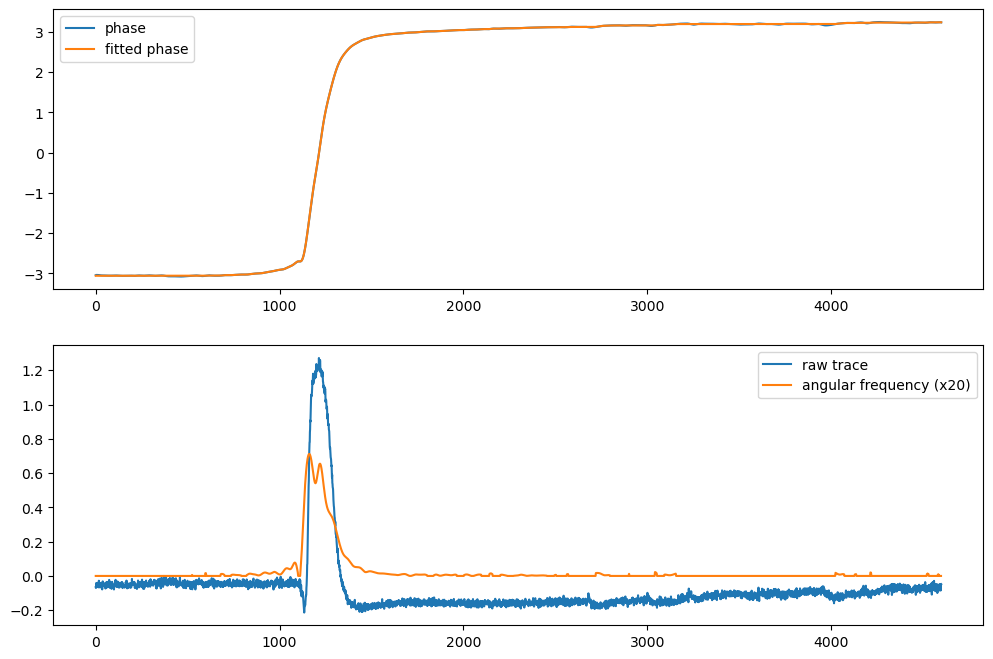

In [10]:
phase = np.unwrap(np.angle(y_hilbert))
phase_corrected = isotonic_phase(phase)

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(phase, label='phase')
plt.plot(phase_corrected, label='fitted phase')
plt.legend()

plt.subplot(212)
plt.plot(y, label='raw trace')
plt.plot(np.diff(phase_corrected)*20, label='angular frequency (x20)')
plt.legend()
plt.show()

From the results above, we can see that the angular frequency increases when the brain shows increased activity. 

### 2-5 Wave propagation between two pixels 

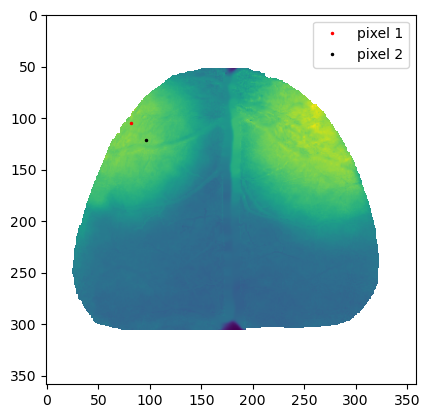

In [11]:
p1, p2 = [82,  105], [96, 121]
y1, y2 = iAdo2m_inpaint[:, p1[0], p1[1]], iAdo2m_inpaint[:, p2[0], p2[1]]
y1_hilbert, phase1 = preprocess(y1, normalized_cutoff)
y2_hilbert, phase2 = preprocess(y2, normalized_cutoff)
# phase1, phase2 = (np.angle(y1_hilbert)), (np.angle(y2_hilbert))
v1, v2 = np.diff(phase1), np.diff(phase2)


plt.figure()
plt.imshow(iAdo2m_inpaint[1157])
plt.plot(p1[0], p1[1], '.', color='red', markersize=3, label='pixel 1')
plt.plot(p2[0], p2[1], '.', color='black', markersize=3, label='pixel 2')
plt.legend()
plt.show()

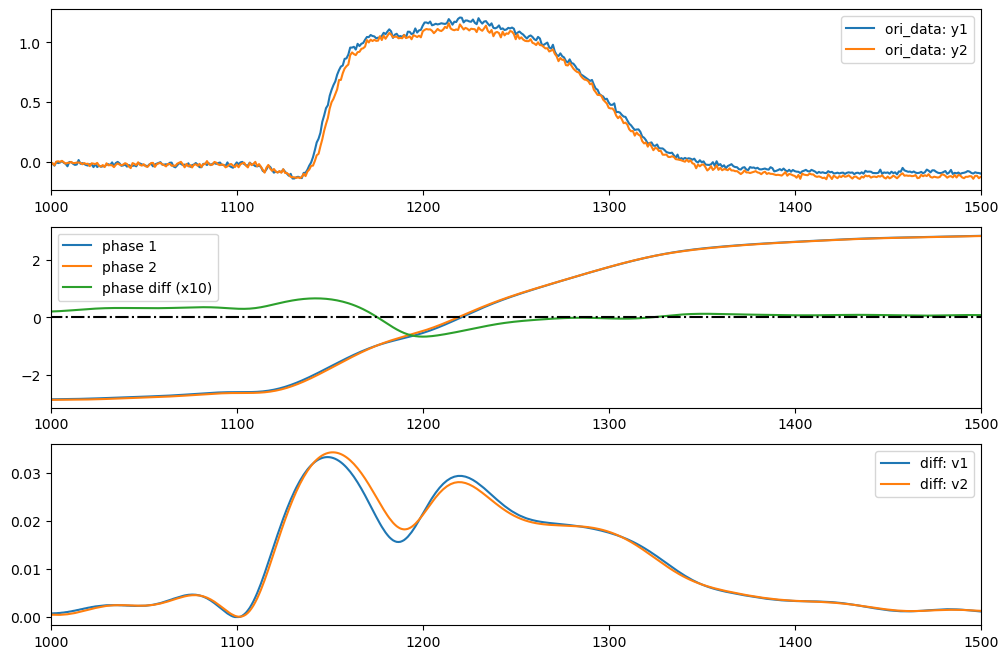

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(y1)
plt.plot(y2)
plt.legend(['ori_data: y1', 'ori_data: y2'])
plt.xlim([1000, 1500])

plt.subplot(312)
plt.plot(phase1, label='phase 1')
plt.plot(phase2, label='phase 2 ')
plt.plot((phase1-phase2)*10, label='phase diff (x10)')
plt.plot(np.zeros_like(phase1), '-.k', markersize=0.1)
plt.legend()
plt.xlim([1000, 1500])
plt.ylim([-np.pi, np.pi])

plt.subplot(313)
plt.plot(v1[1:])
plt.plot(v2[1:])
plt.xlim([1000, 1500])
plt.legend(['diff: v1', 'diff: v2'])
plt.show()

From the phase plot, we can see that the pixel 1 leads  the pixel 2 when the wave propogates from pixel 1 to pixel 2, and then it was lagged behind in the stage of wave disappearing. 

### 2-6 compute wave speed given the instantaenously phase 

Suppose we have two pixels, and we know that the wave is propagating from pixel 1 to pixel 2. We can compute the wave speed by measuring the difference in phase between the two pixels. Here is the derivation for this calculation. 
- At time point $t$, the phases of two pixels are $\phi_1(t)$ and $\phi_2(t)$. Since the wave is propagating from pixel 1 to pixel 2, we know that $\phi_1(t) > \phi_2(t)$. After a small time interval $\Delta t$, the phase of the second pixel $\phi_2(t+\Delta t)$ will be equal to $\phi_1(t)$. In the other word, it takes $\Delta t$ for the wave to travel from pixel 1 to pixel 2. Then the speed  can be easily calculated as 
   $$ \mathbf{v}_{12} = \frac{\Delta \mathbf{s}_{12}}{\Delta t}$$
- If the temporal frequency of the wave $w(t)$ not changing rapidly, we can approximate $\phi_2(t+\Delta t)$ as $\phi_2(t) + w_2(t)\cdot \Delta t$, then we have 
   $$ \Delta t = \frac{\phi_2(t+\Delta t)-\phi_2(t)}{w_2(t)}=\frac{\phi_1(t)-\phi_2(t)}{w_2(t)}$$
   $w_2(t)$ can be easily computed as the gradient of the instantaneous phase $\phi_2'(t)$.
- Combining the above two equations, we  get  
   $$ \mathbf{v}_{12} = \frac{\Delta \mathbf{s}_{12}\cdot w_2(t)}{\phi_1(t)-\phi_2(t)}$$

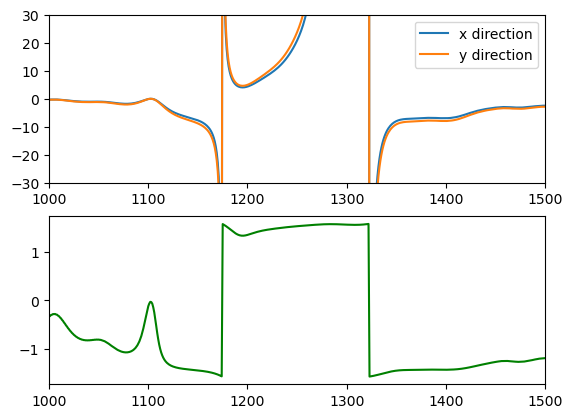

In [13]:
dphi = np.unwrap(phase1 - phase2)
# dphi[np.abs(dphi)<2e-2] = np.inf
dx, dy = p1[0]-p2[0], p1[1]-p2[1]
vx, vy = dx*v2/dphi[1:], dy*v2/dphi[1:]

plt.subplot(211)
plt.plot(vx, label='x direction')
plt.plot(vy, label='y direction')
plt.xlim([1000, 1500])
plt.ylim([-30, 30])
plt.legend() 

plt.subplot(212)
plt.plot(np.arctan(vx, vy), color='green')
plt.xlim([1000, 1500])
plt.show()

-----

## 3. Process all Pixels

### 3-1 Hilbert Transform on every pixel to calculate velocity

In [14]:
class calculate_velocity:

    def __init__(self, 
                 y, 
                 Fs=1, 
                 window='hann', 
                 nperseg=256, 
                 noverlap=128, 
                 freq_band = 0.02, 
                 phase_nan = True, 
                 ) -> None:
        self.y = y
        self.Fs = Fs
        self.window = window
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.freq_band = freq_band
        self.phase_nan = phase_nan

    def spectrogram(self):
        freq, time, spectrogram = signal.spectrogram(self.y, 
                                                     fs=self.Fs, 
                                                     window=self.window, 
                                                     nperseg=self.nperseg, 
                                                     noverlap=self.noverlap)
        return freq, time, spectrogram
    
    def low_pass_filtering(self):
        # Normalize the cutoff frequency
        normalized_cutoff = self.freq_band / (0.5 * Fs)
        # Design the low-pass filter
        b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
        filtered_signal = signal.filtfilt(b, a, self.y)
        return filtered_signal
    
    def hilbert_transform(self):
        # hilbert transform
        filtered_signal = self.low_pass_filtering()
        filtered_signal -= np.ptp(filtered_signal)/2.0
        hilbert_signal = signal.hilbert(filtered_signal)
        return hilbert_signal
    
    def isotonic_phase(self, phase=None): 
        if phase is None:
            phase = np.unwrap(np.angle(self.hilbert_transform()))
        # print(np.any(np.isnan(phase)), np.any(np.isinf(phase)))
        phase = np.nan_to_num(phase, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)
        iso_reg = IsotonicRegression().fit(np.arange(len(phase)), phase)
        phase_pred = iso_reg.predict((np.arange(len(phase))))
        return phase_pred
    

    # main function of this Class
    def preprocess(self):

        # low pass filtering
        b, a = signal.butter(4, normalized_cutoff, btype='low', analog=False)
        if len(self.y.shape)==1:
            self.y = self.y[:, np.newaxis]
        y_filtered = signal.filtfilt(b, a, self.y, axis=0)

        # hilbert trnasform
        y_filtered -= np.ptp(y_filtered,  axis=0)/2.0 
        y_hilbert = signal.hilbert(y_filtered, axis=0)

        # isotonic phase
        phase = np.unwrap(np.angle(y_hilbert), axis=0)
        if len(phase.shape)==2: 
            for i in range(phase.shape[1]): 
                phase[:, i] = self.isotonic_phase(phase[:, i])
                # nan in unnecessary timesteps
                # if self.phase_nan:
                #     if i < 1000 or i > 1500:
                #         phase[:, i] = np.nan
        else: 
            for i in range(phase.shape[1]):
                for j in range(phase.shape[2]):
                    phase[:, i, j] = self.isotonic_phase(phase[:, i, j])
        
        return y_hilbert.squeeze(), phase.squeeze()

In [15]:
# iAdo2m
iAdo2m_Y_hilbert, iAdo2m_Y_phase = calculate_velocity(y=iAdo2m_inpaint[:, brain_mask.astype(bool)]).preprocess()
iAdo2m_phase = np.empty_like(iAdo2m_inpaint[:])
iAdo2m_phase[:, brain_mask.astype(bool)] = iAdo2m_Y_phase
# jRGEC01a
jRGEC01a_Y_hilbert, jRGEC01a_Y_phase = calculate_velocity(y=jRGEC01a_inpaint[:, brain_mask.astype(bool)]).preprocess()
jRGEC01a_phase = np.empty_like(jRGEC01a_inpaint[:])
jRGEC01a_phase[:, brain_mask.astype(bool)] = jRGEC01a_Y_phase

So far we attain the phase of iAdo2m and jRGEC01a. Later we try to visualize the phase.

In [16]:
def visualize_vel(phase, position):
    dphi = np.zeros_like(phase) *1
    for i in range(phase.shape[0]):
        temp = (np.mod(phase[i]-phase[i, position[0], position[1]]+np.pi, np.pi*2)-np.pi)
        dphi[i] = np.abs(temp)<0.005
    
    return dphi

In [17]:
iAdo2m_vel_p1 = visualize_vel(iAdo2m_phase, p1)
iAdo2m_vel_p2 = visualize_vel(iAdo2m_phase, p2)

In [18]:
def process_nan(velocity):

    for i in range(len(velocity)):
        if i < 1120 or i > 1500: # according to spectro
            velocity[i] = np.zeros_like(velocity[i])
    return velocity

iAdo2m_vel_p1 = process_nan(iAdo2m_vel_p1)
iAdo2m_vel_p2 = process_nan(iAdo2m_vel_p2)

In [19]:
# tifffile.imsave('../iAdo2m_vel_p1.tiff', iAdo2m_vel_p1)
# tifffile.imsave('../iAdo2m_vel_p2.tiff', iAdo2m_vel_p2)

In [20]:
iAdo2m_vis = iAdo2m * 1
iAdo2m_vis[np.isnan(iAdo2m_vis)] = 0
iAdo2m_vis = (iAdo2m_vis - iAdo2m_vis.min()) / (iAdo2m_vis.max() - iAdo2m_vis.min())

# iAdo2m_vis_3c = np.zeros((iAdo2m_vis.shape[0], iAdo2m_vis.shape[1], iAdo2m_vis.shape[2], 3))
# iAdo2m_vis_3c[:,:,:,0] = iAdo2m_vel_p1
# iAdo2m_vis_3c[:,:,:,1] = iAdo2m_vis
# # # iAdo2m_3c[:,:,:,2] = iAdo2m_vis
# # for i in range(iAdo2m.shape[0]):
# #     iAdo2m_vis_3c[i] = cv2.cvtColor(iAdo2m_vis[i][..., np.newaxis], cv2.COLOR_GRAY2BGR)

# # iAdo2m_vel_p1_3c = np.zeros((iAdo2m_vel_p1.shape[0], iAdo2m_vel_p1.shape[1], iAdo2m_vel_p1.shape[2], 3), 
# #                             dtype=np.uint8)
# # iAdo2m_vel_p1_3c[:,:,:,0] = iAdo2m_vel_p1

In [21]:
# tifffile.imsave('../iAdo2m_vel_p1_ori.tiff', (iAdo2m_vel_p1[:]+iAdo2m_vis[:])/2)
# tifffile.imsave('../iAdo2m_vel_p1_ori_3c.tiff', iAdo2m_vis_3c[1100:1500])
# del iAdo2m_vis_3c

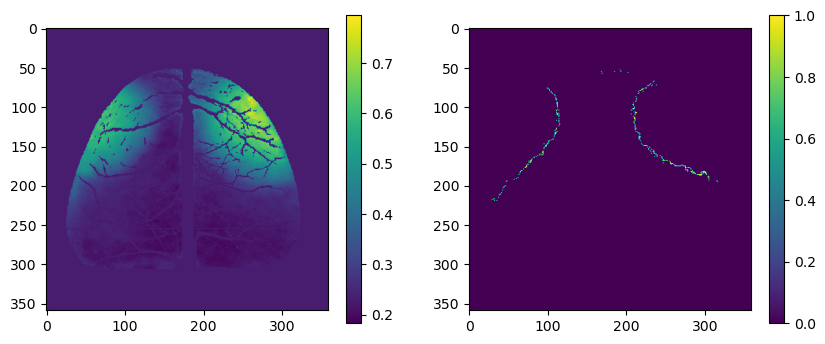

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow((iAdo2m_vis[1150]))
plt.colorbar()
plt.subplot(122)
plt.imshow(iAdo2m_vel_p1[1150])
plt.colorbar()
plt.show()

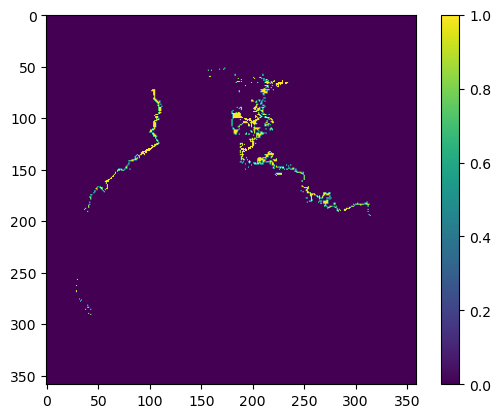

In [23]:
dphi = (np.mod(iAdo2m_phase[1100]-iAdo2m_phase[1100, p1[0], p1[1]]+np.pi, np.pi*2)-np.pi)
plt.imshow(np.abs(dphi)<0.005)
plt.colorbar()
plt.show()

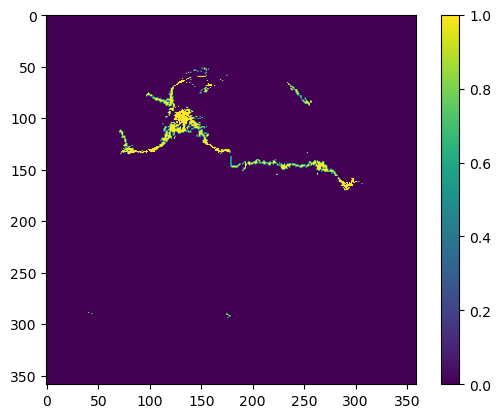

In [24]:
dphi = (np.mod(iAdo2m_phase[1500]-iAdo2m_phase[1500, p1[0], p1[1]]+np.pi, np.pi*2)-np.pi)
plt.imshow(np.abs(dphi)<0.005)
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


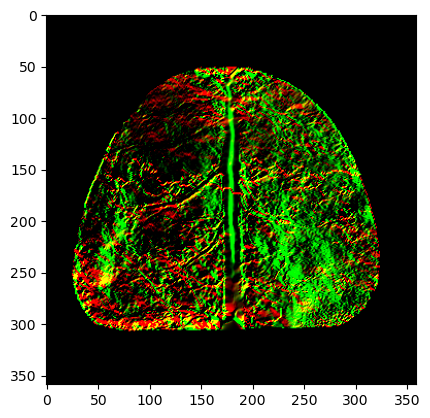

In [25]:
grad_x, grad_y = np.gradient(iAdo2m_phase[1100])

x = np.stack([grad_x, grad_y, np.zeros_like(grad_x)], axis=2)

plt.imshow(x*100)
plt.show()

In order to maximize the display of phase prominence, the phase will be filtered based on the specific conditions of each pixel(angular frequency).

In [94]:
def process_pixel_phase(phase, threshold=0.1, if_vis=False):

    angular_freq = np.diff(phase)*20

    # Initialize variables to store the longest time period
    longest_duration = 0
    longest_start_time = None
    longest_end_time = None

    # Determine the time periods based on the threshold value
    start_time = None
    for i in range(len(angular_freq)):
        if angular_freq[i] >= threshold and start_time is None:
            start_time = i
        elif angular_freq[i] < threshold and start_time is not None:
            end_time = i
            duration = end_time - start_time
            if duration > longest_duration:
                longest_duration = duration
                longest_start_time = start_time
                longest_end_time = end_time
            start_time = None

    # If the last time period hasn't ended, consider it as ongoing
    if start_time is not None and len(angular_freq) > 0:
        end_time = len(angular_freq) - 1
        duration = end_time - start_time
        if duration > longest_duration:
            longest_duration = duration
            longest_start_time = start_time
            longest_end_time = end_time
    
    if if_vis:
        plt.figure(figsize=(10, 2))
        plt.plot(angular_freq, color='red')
        plt.axvline(x=longest_start_time)
        plt.axvline(x=longest_end_time)
        plt.show()
        print(f"Longest Time Period: {longest_start_time} to {longest_end_time}")

    return longest_start_time, longest_end_time

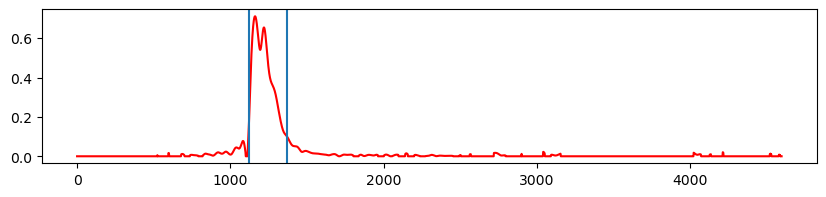

Longest Time Period: 1119 to 1371


(1119, 1371)

In [95]:
process_pixel_phase(iAdo2m_phase[:, 128, 144], if_vis=True)

In [96]:
# apply on every pixel
def pixel_phase(inpaint_data, pos):
    
    phase_process = np.zeros_like(inpaint_data)

    for i in range(pos.shape[1]):
        st, et = process_pixel_phase(inpaint_data[:, pos[:,i][0], pos[:,i][1]])
        phase_process[st:et, pos[:,i][0], pos[:,i][1]] = inpaint_data[st:et, pos[:,i][0], pos[:,i][1]]
    
    return phase_process

In [97]:
# pick non-nan pixels
pos_num = np.asarray(np.nonzero(~np.isnan(iAdo2m[0])))
iAdo2m_phase_process = pixel_phase(iAdo2m_phase, pos_num)
# jRGEC01a_phase_process = pixel_phase(jRGEC01a_phase, pos_num)

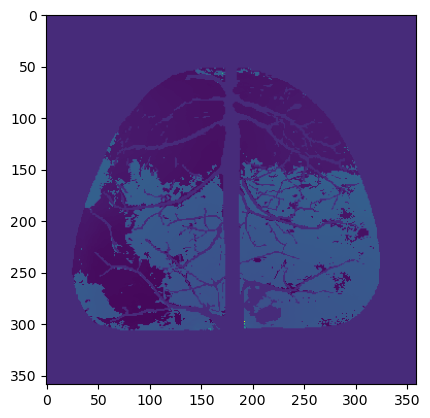

In [98]:
plt.imshow(iAdo2m_phase_process[1150])

In [100]:
iAdo2m_phase_process_pi = (np.mod(iAdo2m_phase_process+np.pi, np.pi*2)-np.pi)
iAdo2m_vis_ = iAdo2m * 1
iAdo2m_vis_[np.isnan(iAdo2m_vis_)] = 0
iAdo2m_vis_ = (iAdo2m_vis_ - iAdo2m_vis_.min()) / (iAdo2m_vis_.max() - iAdo2m_vis_.min())

iAdo2m_vis_3c_ = np.zeros((iAdo2m_vis_.shape[0], iAdo2m_vis_.shape[1], iAdo2m_vis_.shape[2], 3))
iAdo2m_vis_3c_[:,:,:,0] = iAdo2m_vel_p1
iAdo2m_vis_3c_[:,:,:,1] = iAdo2m_vis_

In [93]:
# tifffile.imsave('../iAdo2m_phase_process.tiff', iAdo2m_phase_process)
# tifffile.imsave('../jRGEC01a_phase_process.tiff', jRGEC01a_phase_process)
tifffile.imsave('../iAdo2m_phase_process_pi.tiff', iAdo2m_vis_3c_[1000:1500])